# Classification multi-classe

On cherche à prédire la note d'un vin avec un classifieur multi-classe puis à améliorer le score obtenu avec une méthode dite de [stacking](https://www.quora.com/What-is-stacking-in-machine-learning).

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
clr = OneVsRestClassifier(LogisticRegression())
clr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [5]:
import numpy
numpy.mean(clr.predict(X_test).ravel() == y_test.ravel()) * 100

52.246153846153845

On regarde la matrice de confusion.

In [6]:
from sklearn.metrics import confusion_matrix
import pandas
df = pandas.DataFrame(confusion_matrix(y_test, clr.predict(X_test)))
df.columns = [str(_) for _ in clr.classes_][:df.shape[1]]
df.index = [str(_) for _ in clr.classes_][:df.shape[0]]
df

,3,4,5,6,7,8,9
3,0,0,7,4,0,0,0
4,0,0,30,20,0,0,0
5,0,0,321,208,1,0,0
6,0,0,187,510,6,0,0
7,0,0,19,238,18,0,0
8,0,0,3,48,4,0,0
9,0,0,0,1,0,0,0


On cale d'abord une rando forest sur les données brutes.

In [7]:
from sklearn.ensemble import RandomForestClassifier
mlp = RandomForestClassifier()
mlp.fit(X_train, y_train)
numpy.mean(mlp.predict(X_test).ravel() == y_test.ravel()) * 100

65.66153846153846

On cale un réseau de neurones avec les sorties du modèle précédente.

In [8]:
rf_train = clr.decision_function(X_train)

from sklearn.neural_network import MLPClassifier
rfc = RandomForestClassifier()
rfc.fit(rf_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

On calcule le taux d'erreur.

In [9]:
rf_test = clr.decision_function(X_test)
numpy.mean(rfc.predict(rf_test).ravel() == y_test.ravel()) * 100

64.36923076923077

C'est mieux que le réseau de neurones sur les données brutes mais équivalent à la régression logistique. On trace les courbes ROC pour la classe 4.

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_lr, tpr_lr, th_lr = roc_curve(y_test == 4, clr.decision_function(X_test)[:, 2])
fpr_rfc, tpr_rfc, th_rfc = roc_curve(y_test == 4, rfc.predict_proba(rf_test)[:, 2])
auc_lr = roc_auc_score(y_test == 4, clr.decision_function(X_test)[:, 2])
auc_rfc = roc_auc_score(y_test == 4, rfc.predict_proba(rf_test)[:, 2])
auc_lr, auc_rfc

(0.6771809523809524, 0.6362603174603174)

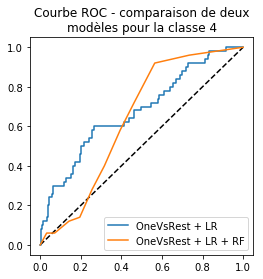

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="OneVsRest + LR + RF")
ax.set_title('Courbe ROC - comparaison de deux\nmodèles pour la classe 4')
ax.legend();

La courbe ROC ne montre rien de probant. Il faudrait vérifier avec une cross-validation qu'il serait pratique de faire avec un [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) mais ceux-ci n'acceptent qu'un seul prédiction final.

In [12]:
from sklearn.pipeline import make_pipeline
try:
    pipe = make_pipeline(OneVsRestClassifier(LogisticRegression()), MLPClassifier())
except Exception as e:
    print('ERREUR :')
    print(e)

ERREUR :
All intermediate steps should be transformers and implement fit and transform. 'OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)' (type <class 'sklearn.multiclass.OneVsRestClassifier'>) doesn't


On construit une ROC sur toutes les classes.

In [13]:
fpr_lr, tpr_lr, th_lr = roc_curve(y_test == clr.predict(X_test), 
                                  clr.predict_proba(X_test).max(axis=1), drop_intermediate=False)
fpr_rfc, tpr_rfc, th_rfc = roc_curve(y_test == rfc.predict(rf_test), 
                                     rfc.predict_proba(rf_test).max(axis=1), drop_intermediate=False)
auc_lr = roc_auc_score(y_test == clr.predict(X_test), 
                       clr.decision_function(X_test).max(axis=1))
auc_rfc = roc_auc_score(y_test == rfc.predict(rf_test), 
                        rfc.predict_proba(rf_test).max(axis=1))
auc_lr, auc_rfc

(0.5577650480249656, 0.7049595960596664)

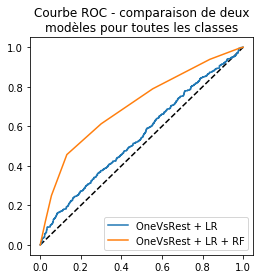

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="OneVsRest + LR + RF")
ax.set_title('Courbe ROC - comparaison de deux\nmodèles pour toutes les classes')
ax.legend();

Sur ce modèle, le score produit par le classifieur final paraît plus partinent que le score obtenu en prenant le score maximum sur toutes les classes. On tente une dernière approche où le modèle final doit valider ou non la réponse : c'est un classifieur binaire. Avec celui-ci, tous les classifieurs estimés sont binaires.

In [15]:
nn_train = clr.decision_function(X_train)
y_train_bin = clr.predict(X_train) == y_train
rfc = RandomForestClassifier()
rfc.fit(nn_train, y_train_bin)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

On regarde les premières réponses.

In [16]:
rf_test = clr.decision_function(X_test)
rfc.predict_proba(rf_test)[:3]

array([[0.7, 0.3],
       [0.6, 0.4],
       [0.1, 0.9]])

In [17]:
y_test_bin = clr.predict(X_test) == y_test

In [18]:
fpr_rfc_bin, tpr_rfc_bin, th_rfc_bin = roc_curve(y_test_bin, rfc.predict_proba(rf_test)[:, 1])
auc_rfc_bin = roc_auc_score(y_test_bin, rfc.predict_proba(rf_test)[:, 1])
auc_lr, auc_rfc_bin

(0.5577650480249656, 0.7450510303206926)

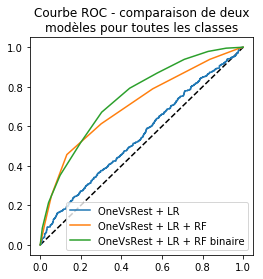

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_lr, tpr_lr, label="OneVsRest + LR")
ax.plot(fpr_rfc, tpr_rfc, label="OneVsRest + LR + RF")
ax.plot(fpr_rfc_bin, tpr_rfc_bin, label="OneVsRest + LR + RF binaire")
ax.set_title('Courbe ROC - comparaison de deux\nmodèles pour toutes les classes')
ax.legend();

Un peu mieux mais il faudrait encore valider avec une validation croisée et plusieurs jeux de données, y compris artificiels. Il reste néanmoins l'idée.